https://www.youtube.com/watch?v=JMT1eGJ9c2M&ab_channel=DecisionForest<br>
https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html<br>
https://towardsdatascience.com/forecasting-time-series-data-stock-price-analysis-324bcc520af5<br>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [27]:
data = pd.read_csv('FAANG.csv',parse_dates=True)
data.index = pd.to_datetime(data.Date)
data.drop('Date',axis=1,inplace=True)
data.dropna(inplace=True)
data

,FB,AMZN,AAPL,NFLX,GOOGL,FB_Ret,AMZN_Ret,AAPL_Ret,NFLX_Ret,GOOGL_Ret
Date,,,,,,,,,,
2012-05-21,34.03,218.11,17.32,10.25,307.36,-0.109861,0.019921,0.058033,0.026026,0.022829
2012-05-22,31.00,215.33,17.19,9.67,300.70,-0.089039,-0.012746,-0.007506,-0.056585,-0.021668
2012-05-23,32.00,217.28,17.61,10.27,305.04,0.032258,0.009056,0.024433,0.062048,0.014433
2012-05-24,33.03,215.24,17.45,10.04,302.13,0.032188,-0.009389,-0.009086,-0.022395,-0.009540
2012-05-25,31.91,212.89,17.35,10.03,296.06,-0.033909,-0.010918,-0.005731,-0.000996,-0.020091
...,...,...,...,...,...,...,...,...,...,...
2020-10-05,264.65,3199.20,116.50,520.65,1482.83,0.018120,0.023744,0.030791,0.034966,0.018707
2020-10-06,258.66,3099.96,113.16,505.87,1451.02,-0.022634,-0.031020,-0.028670,-0.028388,-0.021452
2020-10-07,258.12,3195.69,115.08,534.66,1459.14,-0.002088,0.030881,0.016967,0.056912,0.005596


### FB

In [28]:
# Step 1) Use ADF test to check stationary of the time series (if not stationary, then need to make it stationary)
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['FB'])
if result[1] > 0.05:
    print('ADF test p-value: %.3f; not stationary'%(result[1]))
if result[1] < 0.05:
    print('ADF test p-value: %.3f; stationary'%(result[1]))

ADF test p-value: 0.962; not stationary


In [57]:
# Step 2) Make time series more stationary by taking log of it
d = np.log(data['FB'])
train = d['2012':'2019']
test = d['2020']

In [54]:
# Step 2) Since not stationary, we need to check how many term to difference out so it can be stationary.
# Use the ndiffs package
from pmdarima.arima.utils import ndiffs
n = (ndiffs(train,test='adf'))
print('Difference %s times'%(n))

Difference 1 times


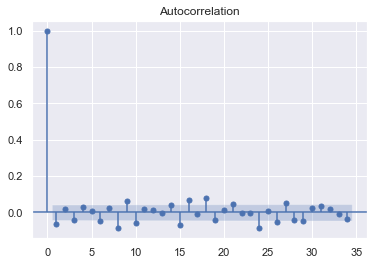

In [31]:
# Check with ACF plot that it is stationary
d = data['FB'].diff(n).dropna()
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(d);

In [58]:
# Step 3) Use autoARIMA to determine order (Can also determine p,q by visually looking at the acf and pacf graph)
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.order)

(0, 1, 0)


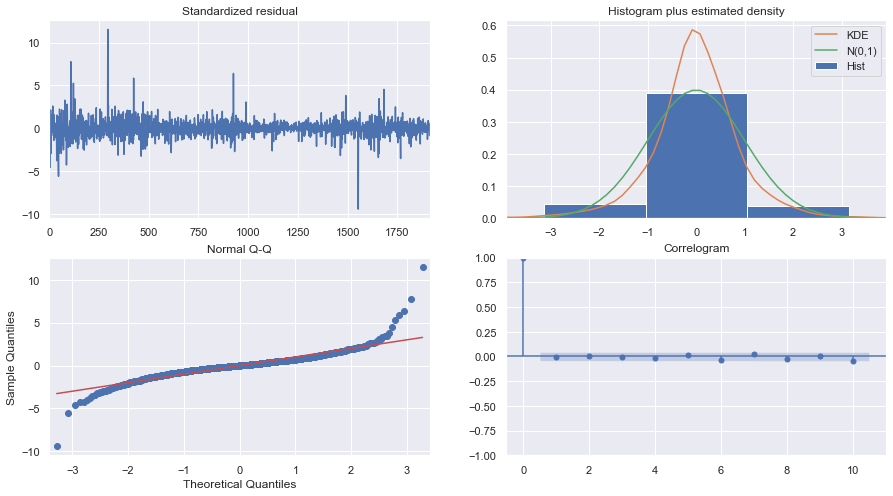

In [59]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [60]:
# Step 5) Built ARIMA model with the determined order
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=model_autoARIMA.order)  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.FB   No. Observations:                 1915
Model:                 ARIMA(0, 1, 0)   Log Likelihood                4557.468
Method:                           css   S.D. of innovations              0.022
Date:                Sun, 10 Jan 2021   AIC                          -9110.935
Time:                        14:57:11   BIC                          -9099.820
Sample:                             1   HQIC                         -9106.845
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.833      0.067   -6.48e-05       0.002


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


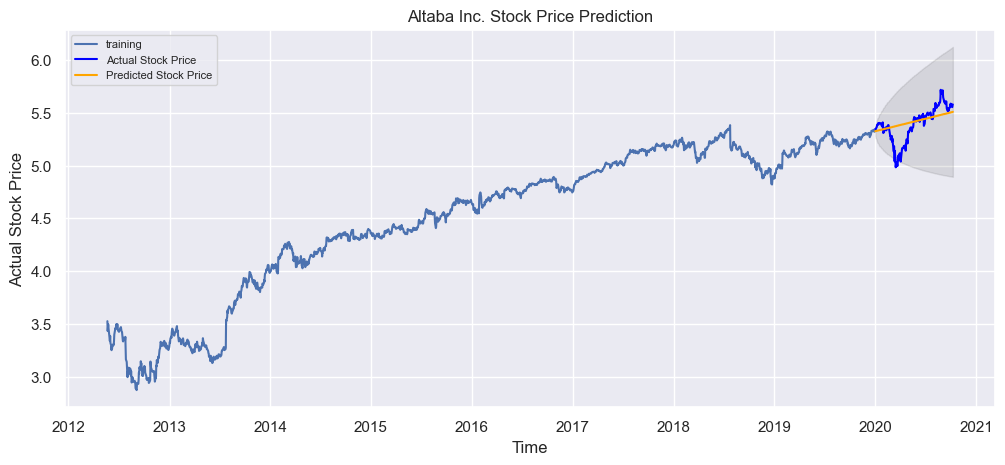

In [61]:
# Step 6) Plot
fc, se, conf = fitted.forecast(196, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
train

Date
2012-05-22   -3.03
2012-05-23    1.00
2012-05-24    1.03
2012-05-25   -1.12
2012-05-29   -3.07
              ... 
2019-12-24   -1.06
2019-12-26    2.67
2019-12-27    0.31
2019-12-30   -3.69
2019-12-31    0.84
Name: FB, Length: 1915, dtype: float64

In [144]:
# Final Step) Report performance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test)/np.abs(test))
print('MAPE: '+str(mape))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))

MSE: 0.008427689369416064
MAE: 0.06643352174668415
RMSE: 0.09180244751321211
MAPE: 0.009263170922569891


### Combine All

In [168]:
def analyze(stock):
    # Step 1) Use ADF test to check stationary of the time series (if not stationary, then need to make it stationary)
    result = adfuller(data[stock])
    if result[1] > 0.05:
        print('ADF test p-value: %.3f; not stationary'%(result[1]))
    if result[1] < 0.05:
        print('ADF test p-value: %.3f; stationary'%(result[1]))
    # Step 2) Make time series more stationary by taking log of it
    d = np.log(data[stock])
    train = d['2012':'2019']
    test = d['2020']
    # Step 3) Use autoARIMA to determine order (Can also determine p,q by visually looking at the acf and pacf graph)
    model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      #seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    # Step 3) # Check with ACF plot that it is stationary
    if model_autoARIMA.order[1] != 0:
        print(model_autoARIMA.order)
        d = data[stock].diff(model_autoARIMA.order[1]).dropna()
        figure = plot_acf(d);
        figure.suptitle('%s'%(stock))
        figure.show()
        figure.savefig('%s_acf.png'%(stock))
        diag = model_autoARIMA.plot_diagnostics(figsize=(15,8))
        diag.suptitle('%s'%(stock))
        diag.show()
        diag.savefig('%s_diag.png'%(stock))
        # Step 4) Built ARIMA model with the determined order
        model = ARIMA(train, order=model_autoARIMA.order)  
        fitted = model.fit()
        # Step 6) Plot
        fc, se, conf = fitted.forecast(196, alpha=0.05)  # 95% confidence
        fc_series = np.exp(pd.Series(fc, index=test.index))
        lower_series = np.exp(pd.Series(conf[:, 0], index=test.index))
        upper_series = np.exp(pd.Series(conf[:, 1], index=test.index))
        f_plot = plt.figure(figsize=(12,5), dpi=100)
        plt.plot(np.exp(train), label='training')
        plt.plot(np.exp(test), color = 'blue', label='Actual Stock Price')
        plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
        plt.title('%s Stock Price Prediction'%(stock))
        plt.xlabel('Time')
        plt.ylabel('Actual Stock Price')
        plt.legend(loc='upper left', fontsize=8)
        plt.show() 
        f_plot.savefig('%s_forecast.png'%(stock))
        #Performance
        mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))
        print(mape)
    if model_autoARIMA.order[1] == 0:
        model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0, 
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
        print(model_autoARIMA.order)
        d = data[stock].diff(model_autoARIMA.order[1]).dropna()
        figure = plot_acf(d);
        figure.suptitle('%s'%(stock))
        figure.show()
        figure.savefig('%s_acf.png'%(stock))
        diag = model_autoARIMA.plot_diagnostics(figsize=(15,8))
        diag.suptitle('%s'%(stock))
        diag.show()
        diag.savefig('%s_diag.png'%(stock))
        # Step 4) Built ARIMA model with the determined order
        model = ARIMA(train, order=model_autoARIMA.order)  
        fitted = model.fit()
        # Step 6) Plot
        fc, se, conf = fitted.forecast(196, alpha=0.05)  # 95% confidence
        fc_series = np.exp(pd.Series(fc, index=test.index))
        lower_series = np.exp(pd.Series(conf[:, 0], index=test.index))
        upper_series = np.exp(pd.Series(conf[:, 1], index=test.index))
        f_plot = plt.figure(figsize=(12,5), dpi=100)
        plt.plot(np.exp(train), label='training')
        plt.plot(np.exp(test), color = 'blue', label='Actual Stock Price')
        plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
        plt.title('%s Stock Price Prediction'%(stock))
        plt.xlabel('Time')
        plt.ylabel('Actual Stock Price')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
        f_plot.savefig('%s_forecast.png'%(stock))
        mape = np.mean(np.abs(np.exp(fc) - np.exp(test))/np.abs(np.exp(test)))
        print(mape)

ADF test p-value: 0.962; not stationary
(0, 1, 0)


<ipython-input-161-9d15e13d6b44>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
<ipython-input-161-9d15e13d6b44>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  diag.show()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been pro

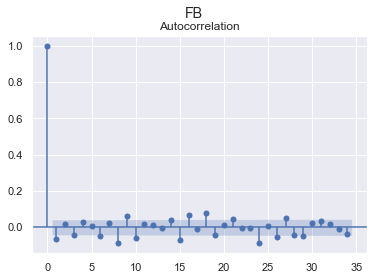

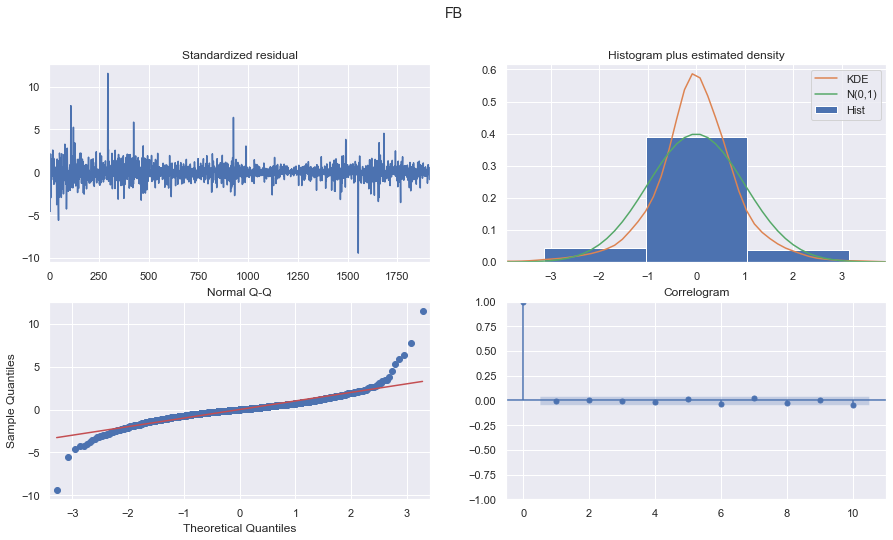

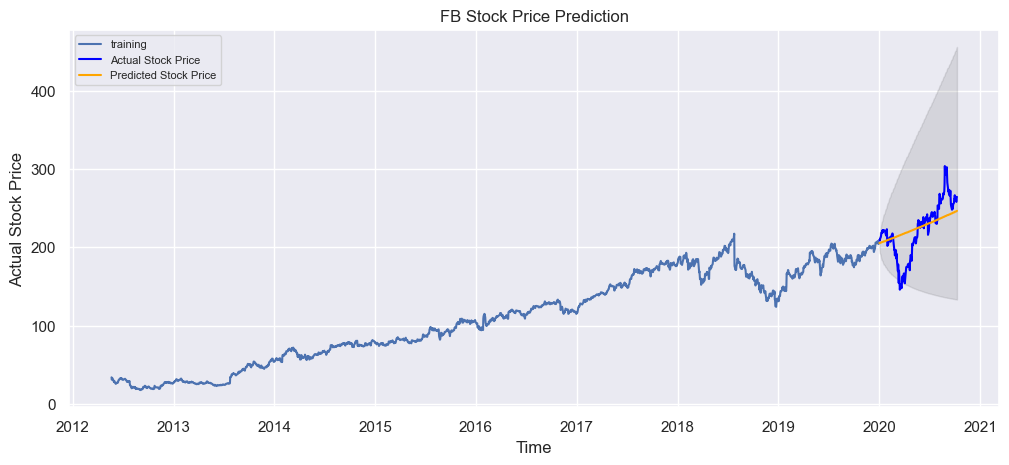

0.1043457857442455


In [162]:
analyze('FB')

ADF test p-value: 1.000; not stationary
(0, 1, 0)


<ipython-input-163-bb08de8eb6b0>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
<ipython-input-163-bb08de8eb6b0>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  diag.show()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been pro

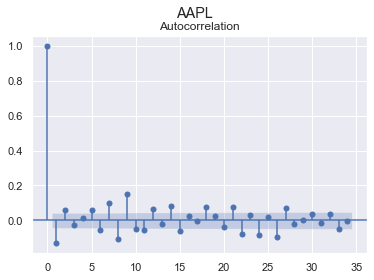

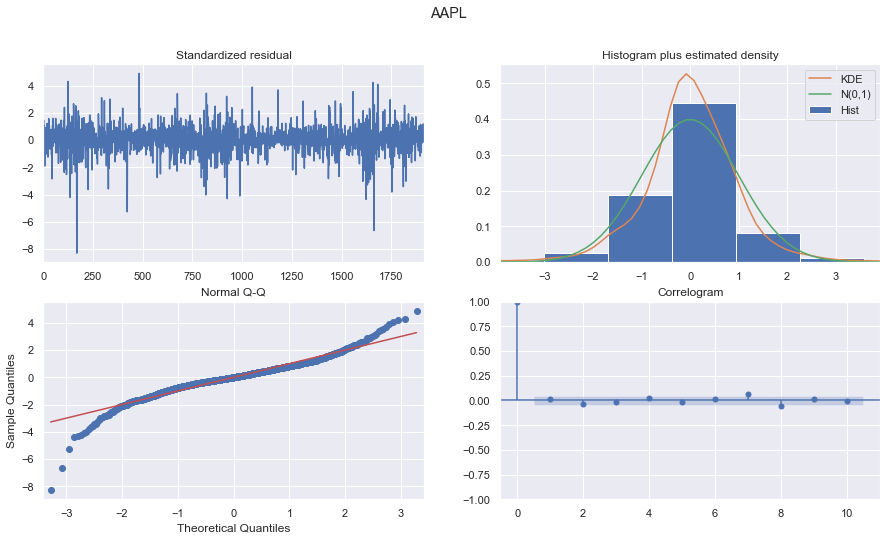

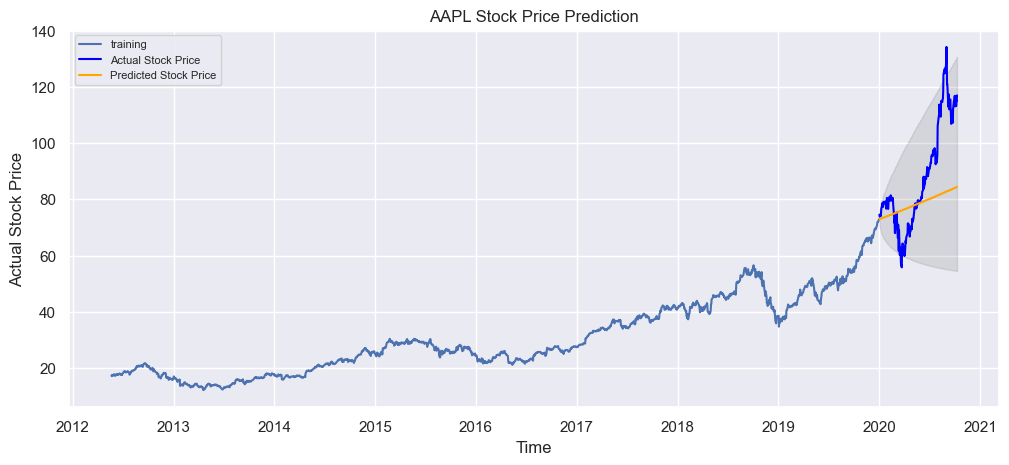

0.1441701828507323


In [164]:
analyze('AAPL')

ADF test p-value: 1.000; not stationary
(0, 1, 0)


<ipython-input-163-bb08de8eb6b0>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
<ipython-input-163-bb08de8eb6b0>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  diag.show()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been pro

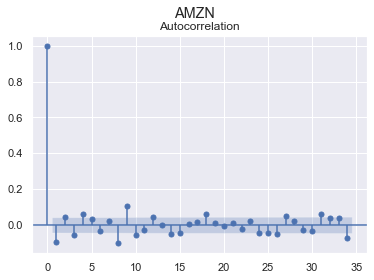

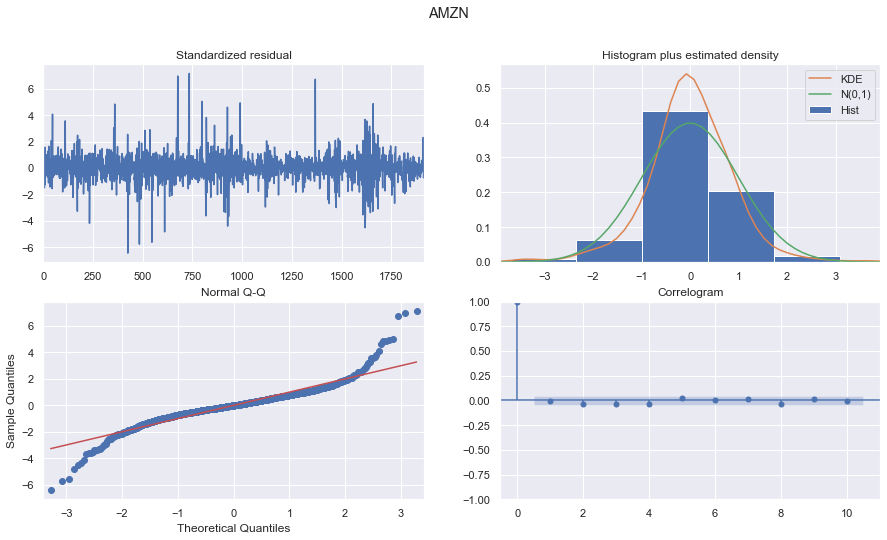

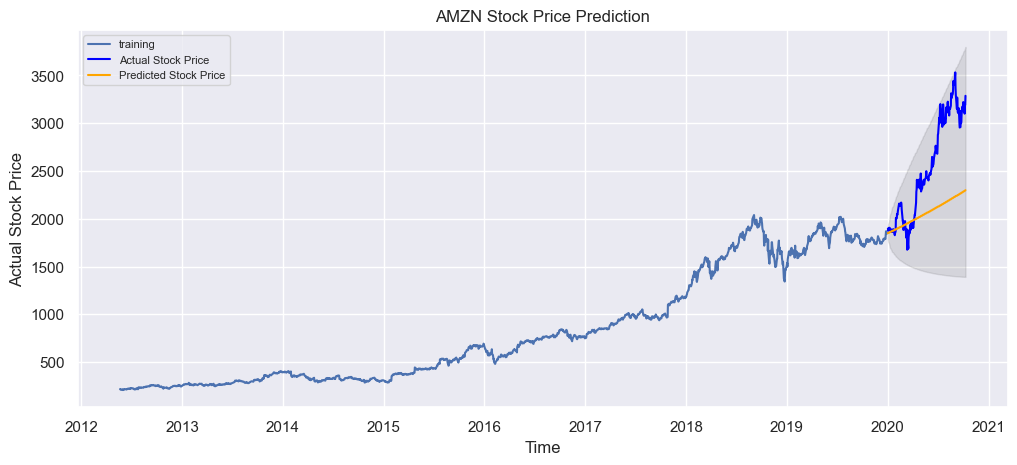

0.17057964458545538


In [165]:
analyze('AMZN')

ADF test p-value: 0.993; not stationary
(0, 1, 1)


<ipython-input-163-bb08de8eb6b0>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
<ipython-input-163-bb08de8eb6b0>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  diag.show()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been pro

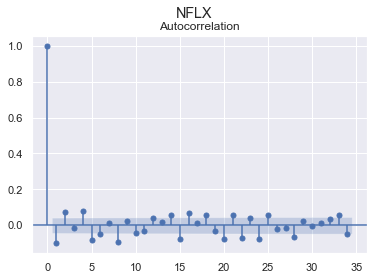

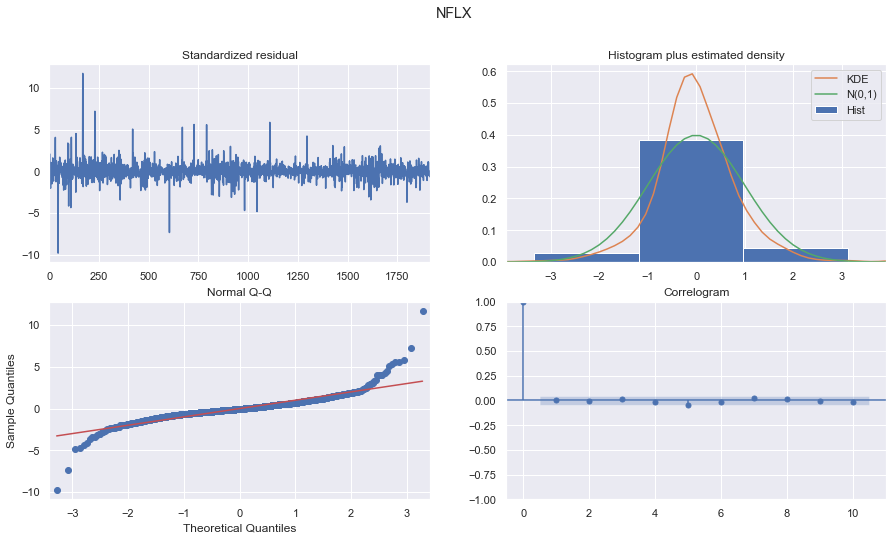

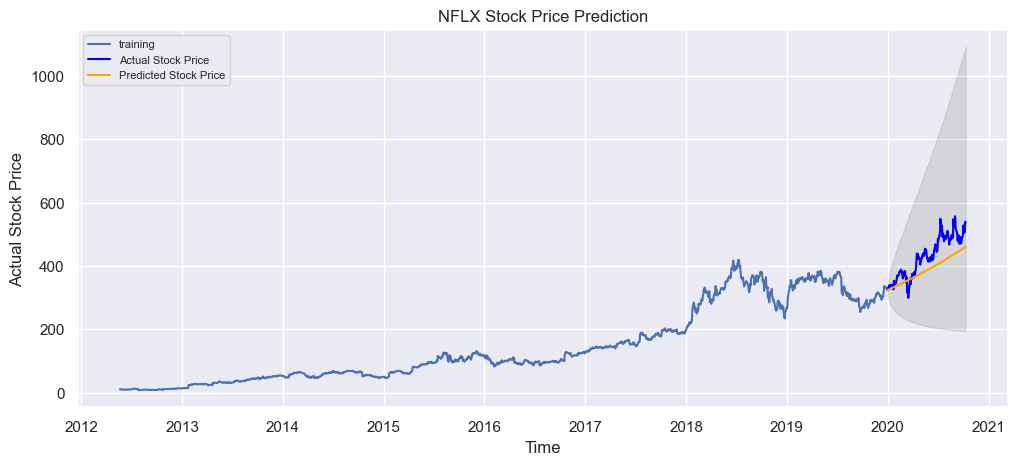

0.09730808476777379


In [166]:
analyze('NFLX')

ADF test p-value: 0.903; not stationary
(0, 1, 0)


<ipython-input-168-a1ae01c137e3>:77: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
<ipython-input-168-a1ae01c137e3>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  diag.show()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been pro

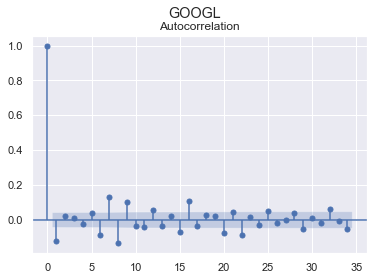

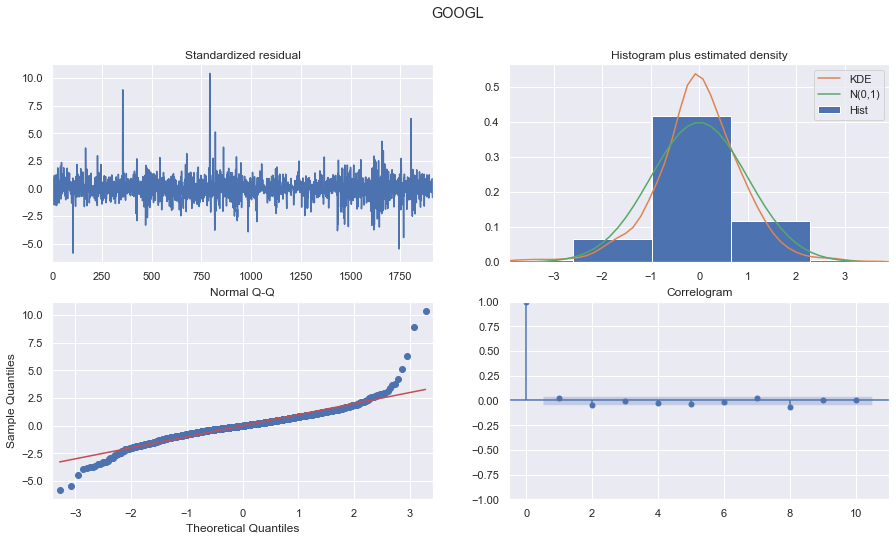

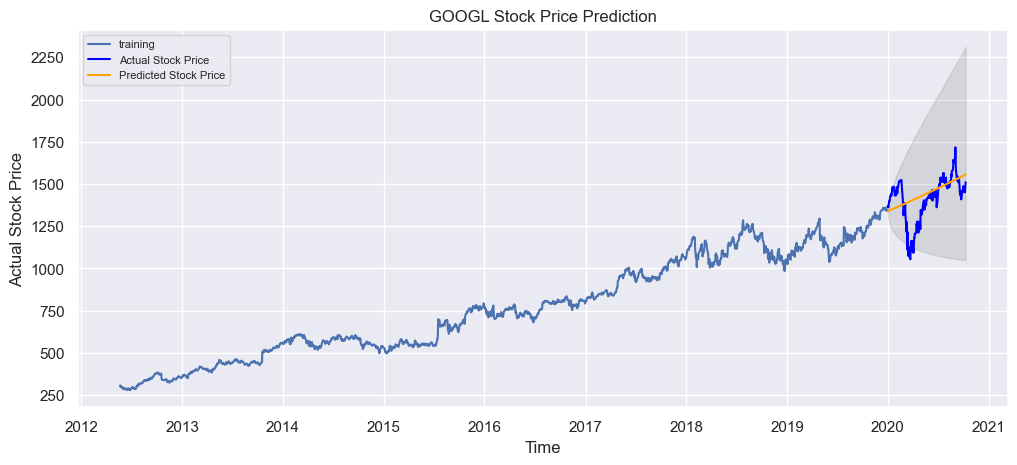

0.06954975036186292


In [169]:
analyze('GOOGL')

### Ljung-Box Test 
Check for the independence of the residue

In [183]:
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model
d = np.log(data['NFLX']) #Manually change the stock name
train = d['2012':'2019']
modelt = arima_model.ARIMA(train,order=(0,1,1)).fit()
stdresid = modelt.resid/math.sqrt(modelt.sigma2)
lbt = stattools.q_stat(stattools.acf(stdresid**2)[1:30],len(stdresid))
lbt[1][-1]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


0.887551470222494